# **Prédiction: SiteEnergyUseWN(kBtu)**

In [2]:
import sys
import importlib.metadata

# Afficher la version de Python
print("Python version:", sys.version)

# Afficher la version des bibliothèques déjà importées
print('\n'.join(f'{m.__name__} - {m.__version__}'
         for m in globals().values()
         if getattr(m, '__version__', None)))

Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
json - 2.0.9
pandas - 2.2.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
df_final=pd.read_csv('df_energy5.csv')

In [4]:
display(df_final.tail())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,BuildingAge,NumberofBuildings_log,NumberofFloors_log,PropertyGFATotal_log,LargestPropertyUseTypeGFA_log,SecondLargestPropertyUseTypeGFA_log,ThirdLargestPropertyUseTypeGFA_log,SteamUse(kBtu)_%_sqrt,TotalGHGEmissions_cat,SiteEnergyUseWN(kBtu)_cat
1605,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,35,0.693147,0.693147,9.416948,9.416948,0.000000,0.000000,0.0,2,1
1606,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,21,0.693147,0.693147,9.680406,9.680406,0.000000,0.000000,0.0,2,1
1607,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,51,0.693147,0.693147,9.484785,8.933796,8.626048,0.000000,0.0,6,5
1608,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,36,0.693147,0.693147,9.554072,8.795128,8.779865,6.184149,0.0,2,0
1609,50226,2016,Nonresidential COS,Mixed Use Property,Van Asselt Community Center,2820 S Myrtle St,Seattle,WA,NaN,7857002030,...,87,0.693147,0.693147,9.812413,9.020632,8.987322,7.011214,0.0,3,1


In [5]:
df_final["SiteEnergyUseWN(kBtu)_log"] = np.log1p(df_final['SiteEnergyUseWN(kBtu)'])

In [6]:
colonnes_quali=['BuildingType',
                'PrimaryPropertyType',
                'Neighborhood', 
                'LargestPropertyUseType', 
                'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType']

In [7]:
colonnes_quanti = ['NumberofBuildings', 
                  'NumberofFloors',
                  'PropertyGFATotal',
                  'LargestPropertyUseTypeGFA',
                  'SecondLargestPropertyUseTypeGFA',
                  'ThirdLargestPropertyUseTypeGFA',
                  'Electricity_%',
                  'NaturalGas(kBtu)_%',
                  'SteamUse(kBtu)_%',
                  'BuildingAge']

In [8]:
colonnes_quanti_transformed = ["NumberofBuildings_log",
                              "NumberofFloors_log",
                              "PropertyGFATotal_log",
                              "LargestPropertyUseTypeGFA_log",
                              "SecondLargestPropertyUseTypeGFA_log",
                              "ThirdLargestPropertyUseTypeGFA_log",
                              'Electricity_%',
                              'NaturalGas(kBtu)_%',
                              "SteamUse(kBtu)_%_sqrt",
                              'BuildingAge']

In [9]:
print(df_final.columns)

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsInte

**Pour la seconde cible nous testerons seulement brut avec brut (modèle de base) et log avec transformé**

## **Split**

### Base

In [13]:
import joblib 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

# Sélection des features (X) et de la cible (y)
# Features transformés hors ES
X_brut= df_final[colonnes_quali + colonnes_quanti] # Features
y_brut = df_final[['SiteEnergyUseWN(kBtu)']] # Cibles à prédire

# Réinitialisation des indices pour éviter tout désalignement
X_brut = X_brut.reset_index(drop=True)
y_brut = y_brut.reset_index(drop=True)

# Affichage des dimensions pour vérification
print("Après nettoyage et réinitialisation :")
print("Taille de X_brut :", X_brut.shape)
print("Taille de y_brut :", y_brut.shape)

# Division des données en jeu d'entraînement et de test
X_train_brut, X_test_brut, y_train_brut, y_test_brut = train_test_split(X_brut, y_brut, test_size=0.2, random_state=42)

# Réassignation des noms de colonne pour les séries
y_train_brut.name = 'SiteEnergyUseWN(kBtu)'
y_test_brut.name = 'SiteEnergyUseWN(kBtu)'

print("Après split :")
print("Taille de X_train_brut:", X_train_brut.shape)
print("Taille de X_test_brut:", X_test_brut.shape)
print("Taille de y_train_brut :", y_train_brut.shape)
print("Taille de y_test_brut :", y_test_brut.shape)

Après nettoyage et réinitialisation :
Taille de X_brut : (1610, 16)
Taille de y_brut : (1610, 1)
Après split :
Taille de X_train_brut: (1288, 16)
Taille de X_test_brut: (322, 16)
Taille de y_train_brut : (1288, 1)
Taille de y_test_brut : (322, 1)


### Transformés

In [15]:
# Sélection des features (X) et de la cible (y)
X_transformed = df_final[colonnes_quali + colonnes_quanti_transformed] 
y_log = df_final[['SiteEnergyUseWN(kBtu)_log']]

# Réinitialisation des indices pour éviter tout désalignement
X_transformed = X_transformed.reset_index(drop=True)
y_log = y_log.reset_index(drop=True)

# Affichage des dimensions pour vérification
print("Après nettoyage et réinitialisation :")
print("Taille de X :", X_transformed.shape)
print("Taille de y_log :", y_log.shape)

# Division des données en jeu d'entraînement et de test
X_train_transformed, X_test_transformed, y_train_log, y_test_log = train_test_split(X_transformed, y_log, test_size=0.2, random_state=42)

# Réassignation des noms de colonne pour les séries
y_train_log.name = 'SiteEnergyUseWN(kBtu)_log'
y_test_log.name = 'SiteEnergyUseWN(kBtu)_log'

print("Taille de X_train_transformed:", X_train_transformed.shape)
print("Taille de X_test_transformed:", X_test_transformed.shape)
print("Taille de y_train_log :", y_train_log.shape)
print("Taille de y_test_log :", y_test_log.shape)

Après nettoyage et réinitialisation :
Taille de X : (1610, 16)
Taille de y_log : (1610, 1)
Taille de X_train_transformed: (1288, 16)
Taille de X_test_transformed: (322, 16)
Taille de y_train_log : (1288, 1)
Taille de y_test_log : (322, 1)


## **Encodage One Hot Encoding et ACP**

### 1. One Hot Encoding

In [18]:
# Encodage OneHot des variables catégorielles
encoder = OneHotEncoder(drop='first', sparse_output=False)  # `drop='first'` pour éviter la multicolinéarité, #sparse_output=False pour utiliser df
quali_encoded_train = encoder.fit_transform(X_train_brut[colonnes_quali])  # Encodage sur les données d'entraînement
quali_encoded_test = encoder.transform(X_test_brut[colonnes_quali])  # Transformation sur le jeu de test

# Conversion en DataFrame pour garder la lisibilité des colonnes
quali_encoded_train_df = pd.DataFrame(quali_encoded_train, columns=encoder.get_feature_names_out(colonnes_quali))
quali_encoded_test_df = pd.DataFrame(quali_encoded_test, columns=encoder.get_feature_names_out(colonnes_quali))

# Réindexation pour éviter tout problème lors de la concaténation
quali_encoded_train_df.index = X_train_brut.index
quali_encoded_test_df.index = X_test_brut.index


### *2. Concaténation features*

In [20]:
# Concaténation des variables numériques et catégorielles encodées
X_train_final_transformed = pd.concat([X_train_transformed[colonnes_quanti_transformed], quali_encoded_train_df], axis=1)
X_test_final_transformed = pd.concat([X_test_transformed[colonnes_quanti_transformed], quali_encoded_test_df], axis=1)

X_train_final_brut = pd.concat([X_train_brut[colonnes_quanti], quali_encoded_train_df], axis=1)
X_test_final_brut = pd.concat([X_test_brut[colonnes_quanti], quali_encoded_test_df], axis=1)

# Vérification des dimensions après transformation
print("\nAprès le split, encodage et concaténation :")
print("Taille de X_train_final_transformed :", X_train_final_transformed.shape)
print("Taille de X_test_final_transformed:", X_test_final_transformed.shape)
print("Taille de X_train_final_brut :", X_train_final_brut.shape)
print("Taille de X_test_final_brut", X_test_final_brut.shape)
print("Taille de y_train_brut :", y_train_brut.shape)
print("Taille de y_test_brut :", y_test_brut.shape)
print("Taille de y_train_log :", y_train_log.shape)
print("Taille de y_test_log :", y_test_log.shape)


Après le split, encodage et concaténation :
Taille de X_train_final_transformed : (1288, 148)
Taille de X_test_final_transformed: (322, 148)
Taille de X_train_final_brut : (1288, 148)
Taille de X_test_final_brut (322, 148)
Taille de y_train_brut : (1288, 1)
Taille de y_test_brut : (322, 1)
Taille de y_train_log : (1288, 1)
Taille de y_test_log : (322, 1)


### **ACP**

In [22]:
# Normalisation des données (centrage et réduction)

#Variante 1: 
scaler = StandardScaler()
X_train_scaled_brut = scaler.fit_transform(X_train_final_brut)  # On ajuste sur l'entraînement
X_test_scaled_brut = scaler.transform(X_test_final_brut)  # On applique la même transformation au test


#Variante 2: 
scaler = StandardScaler()
X_train_scaled_transformed = scaler.fit_transform(X_train_final_transformed)  # On ajuste sur l'entraînement
X_test_scaled_transformed = scaler.transform(X_test_final_transformed)  # On applique la même transformation au test


#  Application de l'ACP Variante 1
pca_brut = PCA(n_components=0.8)  # On garde 80% de la variance expliquée
X_train_pca_brut = pca_brut.fit_transform(X_train_scaled_brut)  # Ajustement et transformation sur train
X_test_pca_brut = pca_brut.transform(X_test_scaled_brut)  # Transformation sur test

#  Application de l'ACP Variante 2
pca_transformed = PCA(n_components=0.8)  # On garde 80% de la variance expliquée
X_train_pca_transformed = pca_transformed.fit_transform(X_train_scaled_transformed)  # Ajustement et transformation sur train
X_test_pca_transformed = pca_transformed.transform(X_test_scaled_transformed)  # Transformation sur test

# Affichage des résultats de l'ACP
print("Variance expliquée totale :", sum(pca_brut.explained_variance_ratio_))
print("Nombre de composantes sélectionnées :", pca_brut.n_components_)

# Affichage des résultats de l'ACP
print("Variance expliquée totale :", sum(pca_transformed.explained_variance_ratio_))
print("Nombre de composantes sélectionnées :", pca_transformed.n_components_)

# Enregistrement de l'objet PCA pour une utilisation ultérieure
joblib.dump(pca_transformed, 'pca_transformed.joblib')
print("L'objet PCA a été sauvegardé dans 'pca_transformed.joblib'")

joblib.dump(pca_brut, 'pca_brut.joblib')
print("L'objet PCA a été sauvegardé dans 'pca_brut.joblib'")


Variance expliquée totale : 0.80052249318423
Nombre de composantes sélectionnées : 78
Variance expliquée totale : 0.8036929013105609
Nombre de composantes sélectionnées : 78
L'objet PCA a été sauvegardé dans 'pca_transformed.joblib'
L'objet PCA a été sauvegardé dans 'pca_brut.joblib'


## **Fonction test de modèle**

In [24]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import time


def test_model(X_train, X_test, y_train, y_test, target, model_name):
    """
    Entraîne et évalue un modèle donné en utilisant la validation croisée et GridSearchCV.
    """

    if model_name == "RandomForest":
        model = RandomForestRegressor(random_state=42)
        param_grid = {
            "n_estimators": [20, 30, 40, 70, 100, 150],
            "min_samples_leaf": [0.02, 0.05, 0.10, 0.15]
        }

    elif model_name == "GradientBoosting":
        model = GradientBoostingRegressor(random_state=42)
        param_grid = {
            "n_estimators": [20, 30, 40, 70, 100, 150],
            "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3]
        }

    elif model_name == "ElasticNet":
        model = ElasticNet(random_state=42)
        param_grid = {
            "alpha": [0.1, 0.5, 1.0, 5.0],
            "l1_ratio": [0.1, 0.5, 0.7, 0.9, 1.0]
        }

    elif model_name == "KNN":
        model = KNeighborsRegressor()
        param_grid = {
            "n_neighbors": [3, 5, 10, 15, 30],
            "weights": ["uniform", "distance"],
            "algorithm": ["auto"]
        }

    else:
        raise ValueError("Modèle inconnu. Choisissez parmi 'RandomForest', 'GradientBoosting', 'ElasticNet', 'KNN'.")

    start_time = time.perf_counter()

    if param_grid:
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1, return_train_score=True)
        grid_search.fit(X_train, y_train[target])
        model = grid_search.best_estimator_
        print(f"Meilleurs paramètres pour {model_name} : {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train[target])

    results = cross_validate(model, X_train, y_train[target], cv=5, scoring=["r2", "neg_mean_squared_error"], return_train_score=True)

    execution_time = time.perf_counter() - start_time

    train_r2 = np.mean(results["train_r2"])
    test_r2_cv = np.mean(results["test_r2"])  # Score R² sur la validation croisée
    train_mse = np.mean(-results["train_neg_mean_squared_error"])
    test_mse_cv = np.mean(-results["test_neg_mean_squared_error"])

    # Évaluation finale sur X_test
    y_pred_test = model.predict(X_test)
    test_r2 = r2_score(y_test[target], y_pred_test)
    test_mse = mean_squared_error(y_test[target], y_pred_test)

    metrics = {
        "Train MSE": train_mse,
        "Test MSE (CV)": test_mse_cv,
        "Test MSE (final)": test_mse,
        "Train R²": train_r2,
        "Test R² (CV)": test_r2_cv,
        "Test R² (final)": test_r2,
        "Overfitting (diff R² train/test CV)": train_r2 - test_r2_cv,
        "Overfitting (diff R² train/test final)": train_r2 - test_r2,
        "Temps d'exécution (s)": execution_time
    }

    return metrics, model


### **Base**

In [26]:
# Définition des modèles à tester
target = 'SiteEnergyUseWN(kBtu)'  
models = ["RandomForest", "GradientBoosting", "ElasticNet", "KNN"]

# Initialisation des variables
best_model_name = None
best_model_instance = None
best_metrics = None

for model_name in models:
    results, trained_model = test_model(X_train_pca_brut, X_test_pca_brut, y_train_brut, y_test_brut, target, model_name)
    
    print(f"\nRésultats pour {model_name} : {results}")  

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs paramètres pour RandomForest : {'min_samples_leaf': 0.02, 'n_estimators': 70}

Résultats pour RandomForest : {'Train MSE': 139831867936741.17, 'Test MSE (CV)': 163104775314608.94, 'Test MSE (final)': 397499095570912.6, 'Train R²': 0.5047257423455062, 'Test R² (CV)': 0.4485642959834955, 'Test R² (final)': 0.32486196422292113, 'Overfitting (diff R² train/test CV)': 0.05616144636201065, 'Overfitting (diff R² train/test final)': 0.17986377812258503, "Temps d'exécution (s)": 88.22727789985947}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs paramètres pour GradientBoosting : {'learning_rate': 0.05, 'n_estimators': 20}

Résultats pour GradientBoosting : {'Train MSE': 81303711696854.9, 'Test MSE (CV)': 163330050817870.06, 'Test MSE (final)': 337880741336269.3, 'Train R²': 0.6997546726033248, 'Test R² (CV)': 0.3507568796442797, 'Test R² (final)': 0.42612161241514845, 'Overfitting (diff R² train/test

### **Transformés**

In [28]:
# Définition des modèles à tester
target_log = 'SiteEnergyUseWN(kBtu)_log'  
models = ["RandomForest", "GradientBoosting", "ElasticNet", "KNN"]

# Initialisation des variables
best_model_name_log = None
best_model_instance_log = None
best_metrics_log = None

for model_name in models:
    results, trained_model = test_model(X_train_pca_transformed, X_test_pca_transformed, y_train_log, y_test_log, target_log, model_name)
    
    print(f"\nRésultats pour {model_name} : {results}") 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs paramètres pour RandomForest : {'min_samples_leaf': 0.02, 'n_estimators': 150}

Résultats pour RandomForest : {'Train MSE': 2.8367404712323747, 'Test MSE (CV)': 3.3945701740280185, 'Test MSE (final)': 5.29243602827862, 'Train R²': 0.3672684341129403, 'Test R² (CV)': 0.25452440241684726, 'Test R² (final)': 0.151301772627637, 'Overfitting (diff R² train/test CV)': 0.11274403169609304, 'Overfitting (diff R² train/test final)': 0.2159666614853033, "Temps d'exécution (s)": 80.1044300000649}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs paramètres pour GradientBoosting : {'learning_rate': 0.2, 'n_estimators': 100}

Résultats pour GradientBoosting : {'Train MSE': 0.19815707722737047, 'Test MSE (CV)': 3.401111435484419, 'Test MSE (final)': 4.67942423932507, 'Train R²': 0.9557061527546253, 'Test R² (CV)': 0.25345294468275564, 'Test R² (final)': 0.24960471211776358, 'Overfitting (diff R² train/test 

### **Sauvergarde du meilleur modèle**

In [30]:
#Sauvegarde du modèle base: 
_, elasticnet_model_brut = test_model(X_train_pca_brut, X_test_pca_brut, y_train_brut, y_test_brut, target, "ElasticNet")
joblib.dump(elasticnet_model_brut, "best_model_ElasticNet_brut.joblib")

#Sauvegarde du modèle variante transformée
#_ car je ne veux pas sauvegarder les metrics du modèle
_, elasticnet_transformed = test_model(X_train_pca_transformed, X_test_pca_transformed, y_train_log, y_test_log, target_log, "ElasticNet")
joblib.dump(elasticnet_transformed, "best_model_ElasticNet_transformed.joblib")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour ElasticNet : {'alpha': 5.0, 'l1_ratio': 0.7}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour ElasticNet : {'alpha': 0.1, 'l1_ratio': 0.1}


['best_model_ElasticNet_transformed.joblib']

## **Ajout de la variable ES**

In [32]:
# Filtrer les lignes où ENERGYSTARScore n'est pas NaN
df_filtered = df_final[df_final["ENERGYSTARScore"].notna()].copy()

# Sélectionner les features explicatives (quantitatives et qualitatives)
features_quanti_ES = ['NumberofBuildings_log',
                      'NumberofFloors_log',
                      'PropertyGFATotal_log',
                      'LargestPropertyUseTypeGFA_log',
                      'SecondLargestPropertyUseTypeGFA_log',
                      'ThirdLargestPropertyUseTypeGFA_log',
                      'Electricity_%',
                      'NaturalGas(kBtu)_%',
                      'SteamUse(kBtu)_%_sqrt',
                      'BuildingAge',
                      'ENERGYSTARScore']

features_quanti_transformed_ES= ["NumberofBuildings_log",
                              "NumberofFloors_log",
                              "PropertyGFATotal_log",
                              "LargestPropertyUseTypeGFA_log",
                              "SecondLargestPropertyUseTypeGFA_log",
                              "ThirdLargestPropertyUseTypeGFA_log",
                              'Electricity_%',
                              'NaturalGas(kBtu)_%',
                              "SteamUse(kBtu)_%_sqrt",
                              'BuildingAge',
                              'ENERGYSTARScore']

features_quali = ['BuildingType',
                  'PrimaryPropertyType',
                  'Neighborhood', 
                  'LargestPropertyUseType', 
                  'SecondLargestPropertyUseType', 
                  'ThirdLargestPropertyUseType']


In [33]:
display(df_filtered.shape)

(1063, 59)

In [34]:
print(df_filtered.isna().mean()*100)

OSEBuildingID                            0.000000
DataYear                                 0.000000
BuildingType                             0.000000
PrimaryPropertyType                      0.000000
PropertyName                             0.000000
Address                                  0.000000
City                                     0.000000
State                                    0.000000
ZipCode                                  0.282220
TaxParcelIdentificationNumber            0.000000
CouncilDistrictCode                      0.000000
Neighborhood                             0.000000
Latitude                                 0.000000
Longitude                                0.000000
YearBuilt                                0.000000
NumberofBuildings                        0.000000
NumberofFloors                           0.000000
PropertyGFATotal                         0.000000
PropertyGFAParking                       0.000000
PropertyGFABuilding(s)                   0.000000


In [35]:
for col in features_quali:
    counts = df_filtered[col].value_counts()  # Compter les occurrences de chaque catégorie
    rare_values = counts[counts == 1]  # Filtrer celles qui apparaissent une seule fois
    
    if not rare_values.empty:  # Vérifier si des valeurs rares existent
        print(f"{col} - Catégories avec une seule occurrence :")
        print(rare_values)
        print("-" * 50)  # Séparateur pour la lisibilité

LargestPropertyUseType - Catégories avec une seule occurrence :
LargestPropertyUseType
Other - Public Services    1
Other                      1
Name: count, dtype: int64
--------------------------------------------------
SecondLargestPropertyUseType - Catégories avec une seule occurrence :
SecondLargestPropertyUseType
Bar/Nightclub                            1
Manufacturing/Industrial Plant           1
Performing Arts                          1
Other - Recreation                       1
Other - Services                         1
Self-Storage Facility                    1
Other - Entertainment/Public Assembly    1
Other - Education                        1
Medical Office                           1
Name: count, dtype: int64
--------------------------------------------------
ThirdLargestPropertyUseType - Catégories avec une seule occurrence :
ThirdLargestPropertyUseType
Other - Recreation                       1
Convenience Store without Gas Station    1
Other - Education               

In [36]:
# Pour 'LargestPropertyUseType'

mapping_largest = {
    "Other - Public Services": "Other"}

# Pour 'SecondLargestPropertyUseType'
mapping_second = {             
    "Manufacturing/Industrial Plant": "Retail Store",                             
    "Other - Education" : "Adult Education",
    "Bar/Nightclub" : "Other - Entertainment/Public Assembly",
    "Performing Arts" : "Other - Entertainment/Public Assembly",
    "Other - Recreation" : "Other - Entertainment/Public Assembly",
    "Other - Services" : "Other",
    "Self-Storage Facility" : "Retail Store",
    "Medical Office" : "Other"}                             

# Pour 'ThirdLargestPropertyUseType'
mapping_third = {                                                       
    "Convenience Store without Gas Station": "Retail Store",              
    "Other - Education": "K-12 School",
    "Worship Facility" :"Social/Meeting Hall",
    "Other - Recreation" : "Other - Entertainment/Public Assembly" ,
    "Pre-school/Daycare" : "K-12 School",
    "Refrigerated Warehouse" : "Retail Store"
}

# Application des mappings aux colonnes concernées dans df_energy3
df_filtered['LargestPropertyUseType'] = df_filtered['LargestPropertyUseType'].replace(mapping_largest)
df_filtered['SecondLargestPropertyUseType'] = df_filtered['SecondLargestPropertyUseType'].replace(mapping_second)
df_filtered['ThirdLargestPropertyUseType']  = df_filtered['ThirdLargestPropertyUseType'].replace(mapping_third)


In [37]:
for col in features_quali:
    counts = df_filtered[col].value_counts()  # Compter les occurrences de chaque catégorie
    rare_values = counts[counts == 1]  # Filtrer celles qui apparaissent une seule fois
    
    if not rare_values.empty:  # Vérifier si des valeurs rares existent
        print(f"{col} - Catégories avec une seule occurrence :")
        print(rare_values)
        print("-" * 50)  # Séparateur pour la lisibilité

### **Split**

#### Base

In [40]:
# Sélection des features (X) et de la cible (y)
# Features transformés hors ES
X_brut_es= df_filtered[features_quali + features_quanti_ES] # Features
y_brut_es = df_filtered[['SiteEnergyUseWN(kBtu)']] # Cibles à prédire

# Réinitialisation des indices pour éviter tout désalignement
X_brut_es = X_brut_es.reset_index(drop=True)
y_brut_es = y_brut_es.reset_index(drop=True)

# Affichage des dimensions pour vérification
print("Après nettoyage et réinitialisation :")
print("Taille de X_brut_es :", X_brut_es.shape)
print("Taille de y_brut_es :", y_brut_es.shape)

# Division des données en jeu d'entraînement et de test
X_train_brut_es, X_test_brut_es, y_train_brut_es, y_test_brut_es = train_test_split(X_brut_es, y_brut_es, test_size=0.2, random_state=42)

# Réassignation des noms de colonne pour les séries
y_train_brut_es.name = 'SiteEnergyUseWN(kBtu)'
y_test_brut_es.name = 'SiteEnergyUseWN(kBtu)'

print("Après split :")
print("Taille de X_train_brut_es:", X_train_brut_es.shape)
print("Taille de X_test_brut_es:", X_test_brut_es.shape)
print("Taille de y_train_brut_es :", y_train_brut_es.shape)
print("Taille de y_test_brut_es :", y_test_brut_es.shape)


Après nettoyage et réinitialisation :
Taille de X_brut_es : (1063, 17)
Taille de y_brut_es : (1063, 1)
Après split :
Taille de X_train_brut_es: (850, 17)
Taille de X_test_brut_es: (213, 17)
Taille de y_train_brut_es : (850, 1)
Taille de y_test_brut_es : (213, 1)


#### Variante 3 : Cible Log, Features transformés

In [42]:
print(df_filtered.columns)  # Liste des colonnes disponibles

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsInte

In [43]:
# Sélection des features (X) et de la cible (y)
# Features transformés hors ES
X_transformed_es = df_filtered[features_quali + features_quanti_transformed_ES] # Features
y_log_es = df_filtered[['SiteEnergyUseWN(kBtu)_log']]

# Réinitialisation des indices pour éviter tout désalignement
X_transformed_es = X_transformed_es.reset_index(drop=True)
y_log_es = y_log_es.reset_index(drop=True)

# Affichage des dimensions pour vérification
print("Après nettoyage et réinitialisation :")
print("Taille de X_es :", X_transformed_es.shape)
print("Taille de y_log_es :", y_log_es.shape)

# Division des données en jeu d'entraînement et de test
X_train_transformed_es, X_test_transformed_es, y_train_log_es, y_test_log_es = train_test_split(X_transformed_es, y_log_es, test_size=0.2, random_state=42)

# Réassignation des noms de colonne pour les séries
y_train_log_es.name = 'SiteEnergyUseWN(kBtu)_log'
y_test_log_es.name = 'SiteEnergyUseWN(kBtu)_log'

print("Taille de X_train_transformed_es:", X_train_transformed_es.shape)
print("Taille de X_test_transformed_es:", X_test_transformed_es.shape)
print("Taille de y_train_log_es :", y_train_log_es.shape)
print("Taille de y_test_log_es :", y_test_log_es.shape)

Après nettoyage et réinitialisation :
Taille de X_es : (1063, 17)
Taille de y_log_es : (1063, 1)
Taille de X_train_transformed_es: (850, 17)
Taille de X_test_transformed_es: (213, 17)
Taille de y_train_log_es : (850, 1)
Taille de y_test_log_es : (213, 1)


### **Encodage des variables qualitatives**

#### a. One Hot Encoding

In [46]:
# Encodage OneHot des variables catégorielles
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')  # `drop='first'` pour éviter la multicolinéarité, #sparse_output=False pour utiliser df
quali_encoded_train_es = encoder.fit_transform(X_train_brut_es[features_quali])  # Encodage sur les données d'entraînement
quali_encoded_test_es = encoder.transform(X_test_brut_es[features_quali])  # Transformation sur le jeu de test

# Conversion en DataFrame pour garder la lisibilité des colonnes
quali_encoded_train_df_es = pd.DataFrame(quali_encoded_train_es, columns=encoder.get_feature_names_out(features_quali))
quali_encoded_test_df_es = pd.DataFrame(quali_encoded_test_es, columns=encoder.get_feature_names_out(features_quali))

# Réindexation pour éviter tout problème lors de la concaténation
quali_encoded_train_df_es.index = X_train_brut_es.index
quali_encoded_test_df_es.index = X_test_brut_es.index

#### b. Concaténation variables quanti et variables quali

In [48]:
# Concaténation des variables numériques et catégorielles encodées
X_train_final_transformed_es = pd.concat([X_train_transformed_es[features_quanti_transformed_ES], quali_encoded_train_df_es], axis=1)
X_test_final_transformed_es = pd.concat([X_test_transformed_es[features_quanti_transformed_ES], quali_encoded_test_df_es], axis=1)

X_train_final_brut_es = pd.concat([X_train_brut_es[features_quanti_ES], quali_encoded_train_df_es], axis=1)
X_test_final_brut_es = pd.concat([X_test_brut_es[features_quanti_ES], quali_encoded_test_df_es], axis=1)

# Vérification des dimensions après transformation
print("\nAprès le split, encodage et concaténation :")
print("Taille de X_train_final_transformed_es :", X_train_final_transformed_es.shape)
print("Taille de X_test_final_transformed_es:", X_test_final_transformed_es.shape)
print("Taille de X_train_final_brut_es :", X_train_final_brut_es.shape)
print("Taille de X_test_final_brut_es", X_test_final_brut_es.shape)
print("Taille de y_train_brut_es :", y_train_brut_es.shape)
print("Taille de y_test_brut_es :", y_test_brut_es.shape)
print("Taille de y_train_log_es :", y_train_log_es.shape)
print("Taille de y_test_log_es :", y_test_log_es.shape)


Après le split, encodage et concaténation :
Taille de X_train_final_transformed_es : (850, 98)
Taille de X_test_final_transformed_es: (213, 98)
Taille de X_train_final_brut_es : (850, 98)
Taille de X_test_final_brut_es (213, 98)
Taille de y_train_brut_es : (850, 1)
Taille de y_test_brut_es : (213, 1)
Taille de y_train_log_es : (850, 1)
Taille de y_test_log_es : (213, 1)


### **ACP**

In [50]:
# Normalisation des données (centrage et réduction)

#Variante 1: 
scaler = StandardScaler()
X_train_scaled_brut_es = scaler.fit_transform(X_train_final_brut_es)  # On ajuste sur l'entraînement
X_test_scaled_brut_es = scaler.transform(X_test_final_brut_es)  # On applique la même transformation au test


#Variante 2: 
scaler = StandardScaler()
X_train_scaled_transformed_es = scaler.fit_transform(X_train_final_transformed_es)  # On ajuste sur l'entraînement
X_test_scaled_transformed_es = scaler.transform(X_test_final_transformed_es)  # On applique la même transformation au test


#  Application de l'ACP Variante 1
pca_brut_es = PCA(n_components=0.8)  # On garde 80% de la variance expliquée
X_train_pca_brut_es = pca_brut_es.fit_transform(X_train_scaled_brut_es)  # Ajustement et transformation sur train
X_test_pca_brut_es = pca_brut_es.transform(X_test_scaled_brut_es)  # Transformation sur test

#  Application de l'ACP Variante 2
pca_transformed_es = PCA(n_components=0.8)  # On garde 80% de la variance expliquée
X_train_pca_transformed_es = pca_transformed_es.fit_transform(X_train_scaled_transformed_es)  # Ajustement et transformation sur train
X_test_pca_transformed_es = pca_transformed_es.transform(X_test_scaled_transformed_es)  # Transformation sur test

# Affichage des résultats de l'ACP
print("Variance expliquée totale :", sum(pca_brut_es.explained_variance_ratio_))
print("Nombre de composantes sélectionnées :", pca_brut_es.n_components_)

# Affichage des résultats de l'ACP
print("Variance expliquée totale :", sum(pca_transformed_es.explained_variance_ratio_))
print("Nombre de composantes sélectionnées :", pca_transformed_es.n_components_)

# Enregistrement de l'objet PCA pour une utilisation ultérieure
joblib.dump(pca_transformed_es, 'pca_transformed_es.joblib')
print("L'objet PCA a été sauvegardé dans 'pca_transformed_es_total.joblib'")

joblib.dump(pca_brut_es, 'pca_brut_es_total.joblib')
print("L'objet PCA a été sauvegardé dans 'pca_brut_es.joblib'")


Variance expliquée totale : 0.8005618849412874
Nombre de composantes sélectionnées : 47
Variance expliquée totale : 0.8005618849412874
Nombre de composantes sélectionnées : 47
L'objet PCA a été sauvegardé dans 'pca_transformed_es_total.joblib'
L'objet PCA a été sauvegardé dans 'pca_brut_es.joblib'


### **Modèles**

In [52]:
# Définition des modèles à tester
target = 'SiteEnergyUseWN(kBtu)'  
models = ["RandomForest", "GradientBoosting", "ElasticNet", "KNN"]

# Initialisation des variables
best_model_name_es = None
best_model_instance_es = None
best_metrics_es = None

for model_name in models:
    results, trained_model = test_model(X_train_pca_brut_es, X_test_pca_brut_es, y_train_brut_es, y_test_brut_es, target, model_name)
    
    print(f"\nRésultats pour {model_name} : {results}")  

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs paramètres pour RandomForest : {'min_samples_leaf': 0.02, 'n_estimators': 100}

Résultats pour RandomForest : {'Train MSE': 258705475193642.6, 'Test MSE (CV)': 315062311954305.06, 'Test MSE (final)': 367142986059056.9, 'Train R²': 0.3864074921766794, 'Test R² (CV)': 0.3618621225465518, 'Test R² (final)': 0.382881468423384, 'Overfitting (diff R² train/test CV)': 0.0245453696301276, 'Overfitting (diff R² train/test final)': 0.0035260237532954153, "Temps d'exécution (s)": 35.84147119987756}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs paramètres pour GradientBoosting : {'learning_rate': 0.01, 'n_estimators': 20}

Résultats pour GradientBoosting : {'Train MSE': 310796329318624.1, 'Test MSE (CV)': 393563557313653.1, 'Test MSE (final)': 435915087953471.1, 'Train R²': 0.25779030289793364, 'Test R² (CV)': 0.013862859934804095, 'Test R² (final)': 0.26728471144845567, 'Overfitting (diff R² train/te

Meilleur modèle ElasticNet

In [54]:
# Définition des modèles à tester
target_log = 'SiteEnergyUseWN(kBtu)_log'  
models = ["RandomForest", "GradientBoosting", "ElasticNet", "KNN"]

# Initialisation des variables
best_model_name_var3_es = None
best_model_instance_var3_es = None
best_metrics_var3_es = None

for model_name in models:
    results, trained_model = test_model(X_train_pca_transformed_es, X_test_pca_transformed_es, y_train_log_es, y_test_log_es, target_log, model_name)
    
    print(f"\nRésultats pour {model_name} : {results}") 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs paramètres pour RandomForest : {'min_samples_leaf': 0.02, 'n_estimators': 150}

Résultats pour RandomForest : {'Train MSE': 1.8555725833174583, 'Test MSE (CV)': 2.474873679082033, 'Test MSE (final)': 0.5486855523484996, 'Train R²': 0.4572108268027561, 'Test R² (CV)': 0.34262631761167395, 'Test R² (final)': 0.6217011986080859, 'Overfitting (diff R² train/test CV)': 0.11458450919108215, 'Overfitting (diff R² train/test final)': -0.16449037180532983, "Temps d'exécution (s)": 34.618588000070304}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs paramètres pour GradientBoosting : {'learning_rate': 0.05, 'n_estimators': 150}

Résultats pour GradientBoosting : {'Train MSE': 0.30968671380320684, 'Test MSE (CV)': 2.510611491213416, 'Test MSE (final)': 0.8407646056393472, 'Train R²': 0.9095481764471585, 'Test R² (CV)': 0.323182060408985, 'Test R² (final)': 0.4203232776865732, 'Overfitting (diff R² train

### **Sauvergarde du meilleur modèle**

In [56]:
#Sauvegarde du modèle brut
#_ car je ne veux pas sauvegarder les metrics du modèle
_, elasticNet_model_conso_brut_es = test_model(X_train_pca_brut_es, X_test_pca_brut_es, y_train_brut_es, y_test_brut_es, target, "ElasticNet")
joblib.dump(elasticNet_model_conso_brut_es, "best_model_ElasticNet_conso_brut_es.joblib")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour ElasticNet : {'alpha': 5.0, 'l1_ratio': 0.7}


['best_model_ElasticNet_conso_brut_es.joblib']

In [57]:
#Sauvegarde du modèle variante 3 
#_ car je ne veux pas sauvegarder les metrics du modèle
_, elasticNet_model_conso_log_es = test_model(X_train_pca_transformed_es, X_test_pca_transformed_es, y_train_log_es, y_test_log_es, target_log, "ElasticNet")
joblib.dump(elasticNet_model_conso_log_es, "best_model_ElasticNet_log_es.joblib")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour ElasticNet : {'alpha': 0.1, 'l1_ratio': 0.5}


['best_model_ElasticNet_log_es.joblib']

## **Feature Importance**

In [59]:
best_model      = joblib.load('best_model_ElasticNet_brut.joblib')
best_model_transformed  = joblib.load('best_model_ElasticNet_transformed.joblib')
pca_brut        = joblib.load('pca_brut.joblib')
pca_transformed = joblib.load ('pca_transformed.joblib')

# Pour la version avec Energystarscore (ES)
best_model_es      = joblib.load('best_model_ElasticNet_conso_brut_es.joblib')
best_model_log_es  = joblib.load('best_model_ElasticNet_log_es.joblib')
pca_brut_es        = joblib.load('pca_brut_es_total.joblib')
pca_transformed_es = joblib.load('pca_transformed_es_total.joblib')


=== Traitement de la variante : brute ===


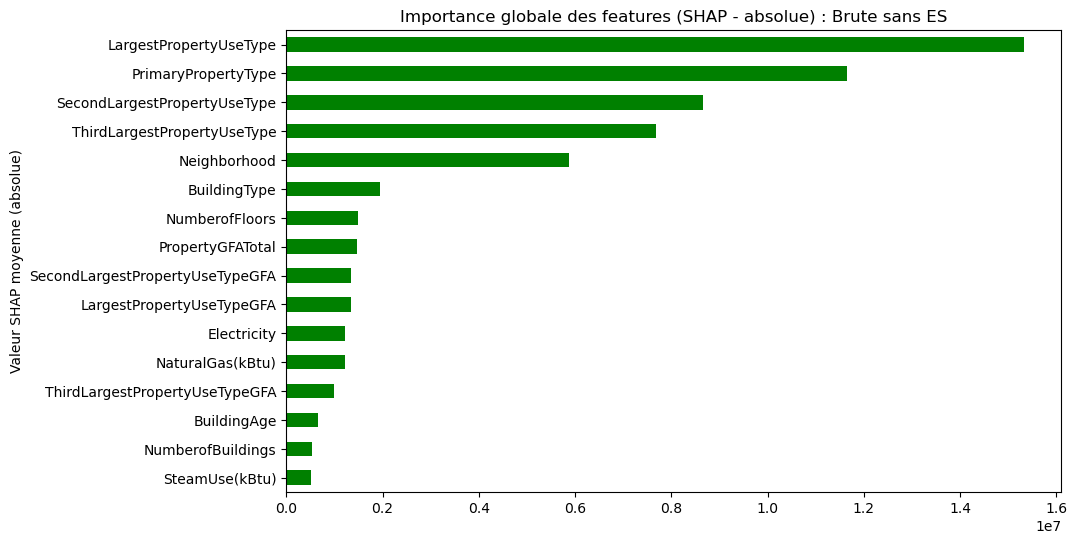

shap_aggregated_matrix.shape: (322, 16)
X_aggregated.shape: (322, 16)
Exemple d'observation agrégée: BuildingAge                        0.025705
BuildingType                       3.054352
Electricity                       -1.284309
LargestPropertyUseType            -1.722056
LargestPropertyUseTypeGFA          0.267690
NaturalGas(kBtu)                   1.029690
Neighborhood                       1.223107
NumberofBuildings                 -0.109428
NumberofFloors                    -0.238245
PrimaryPropertyType               -0.024885
PropertyGFATotal                   0.108330
SecondLargestPropertyUseType      -2.713328
SecondLargestPropertyUseTypeGFA   -0.326616
SteamUse(kBtu)                    -0.443983
ThirdLargestPropertyUseType       -1.815778
ThirdLargestPropertyUseTypeGFA    -0.157310
Name: 0, dtype: float64


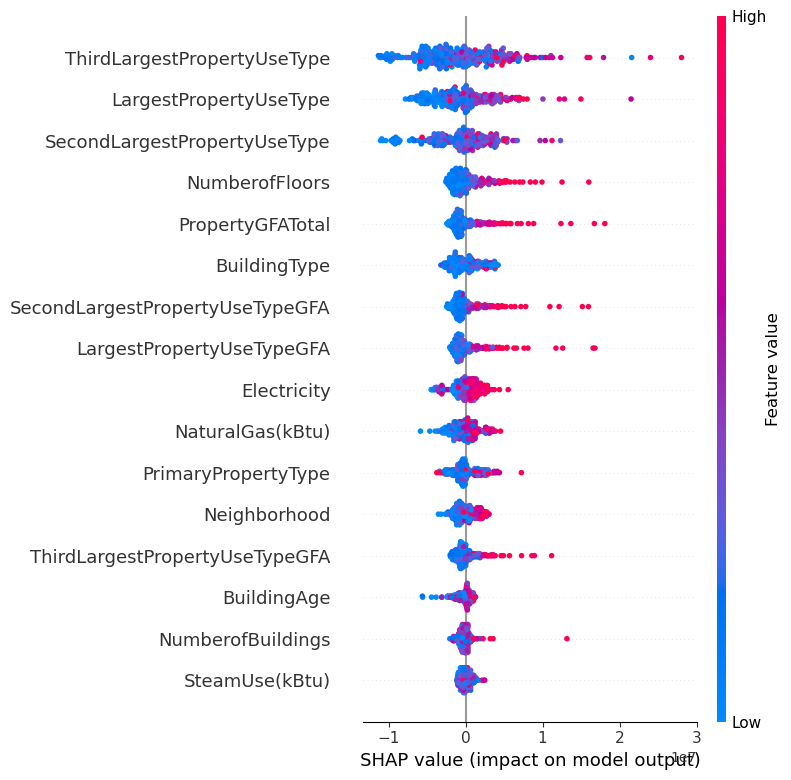

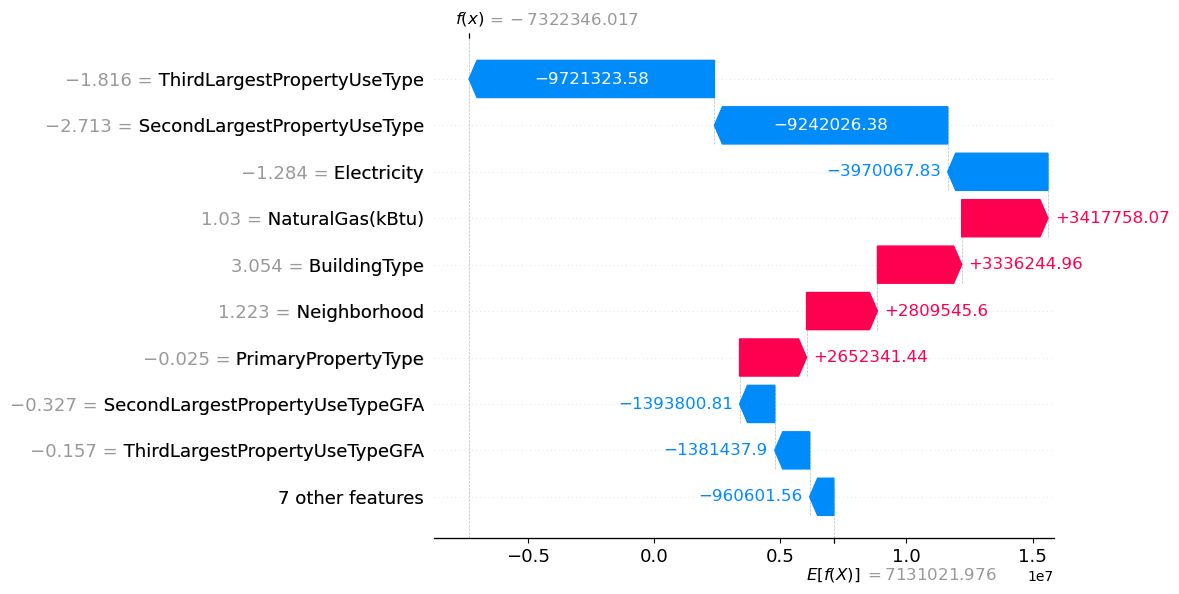

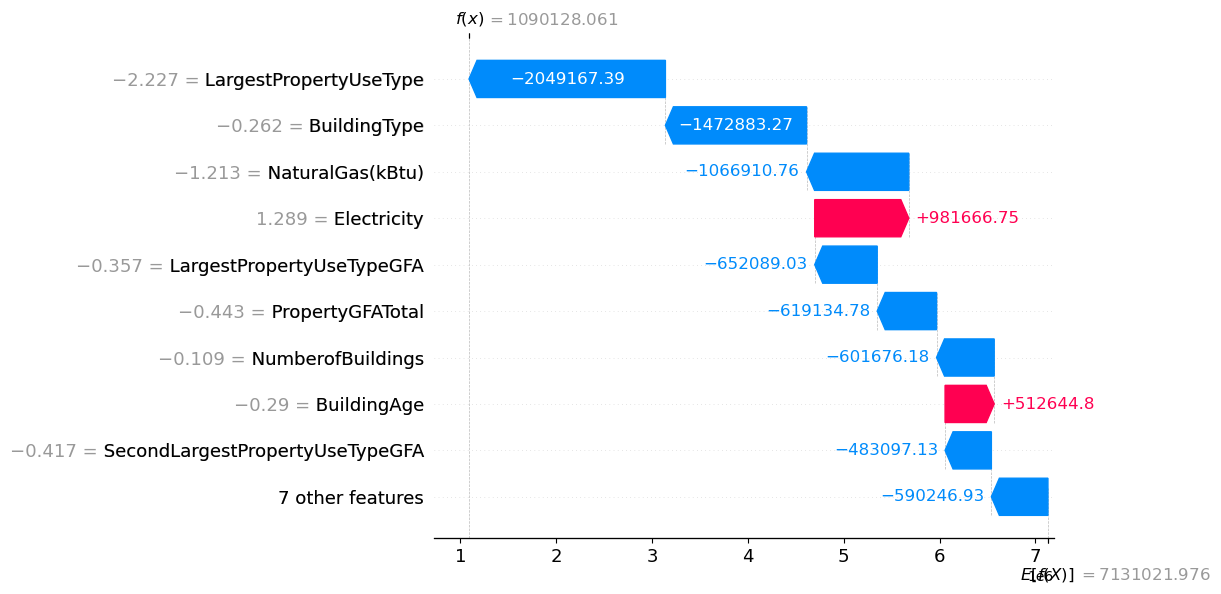


=== Traitement de la variante : Transformé ===


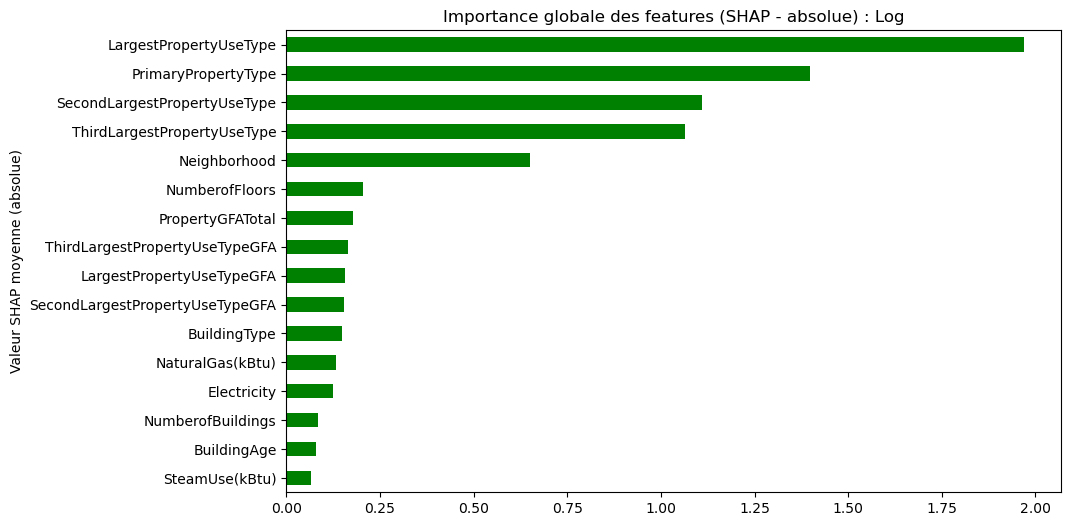

shap_aggregated_matrix.shape: (322, 16)
X_aggregated.shape: (322, 16)
Exemple d'observation agrégée: BuildingAge                       -0.072074
BuildingType                       3.059528
Electricity                       -1.256565
LargestPropertyUseType            -1.943385
LargestPropertyUseTypeGFA          0.798554
NaturalGas(kBtu)                   0.992030
Neighborhood                       1.188965
NumberofBuildings                 -0.011125
NumberofFloors                    -0.196293
PrimaryPropertyType               -0.032466
PropertyGFATotal                   0.527926
SecondLargestPropertyUseType      -2.764218
SecondLargestPropertyUseTypeGFA   -1.231953
SteamUse(kBtu)                    -0.442049
ThirdLargestPropertyUseType       -1.436321
ThirdLargestPropertyUseTypeGFA    -0.505289
Name: 0, dtype: float64


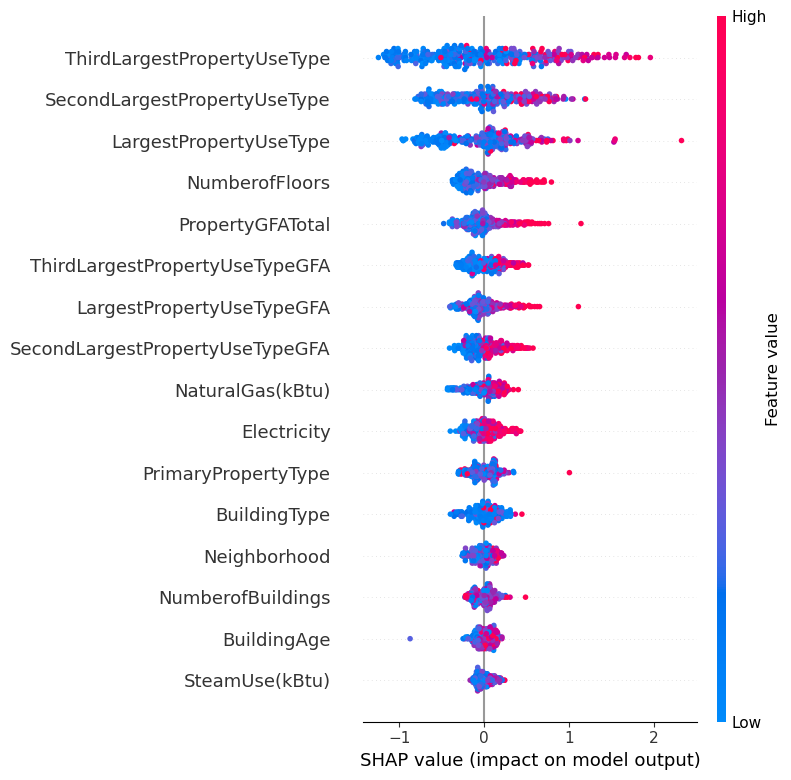

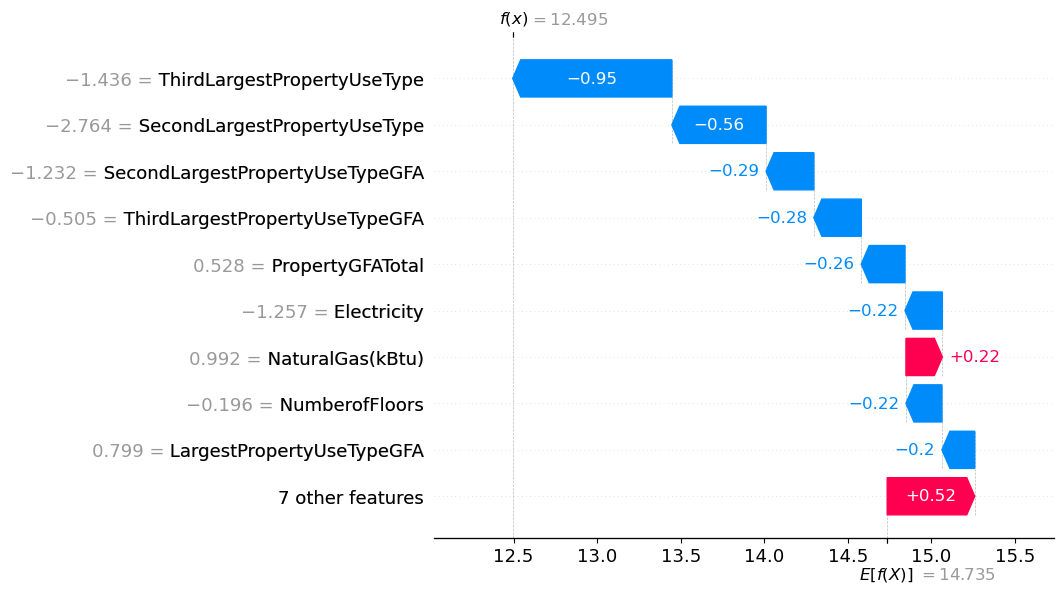

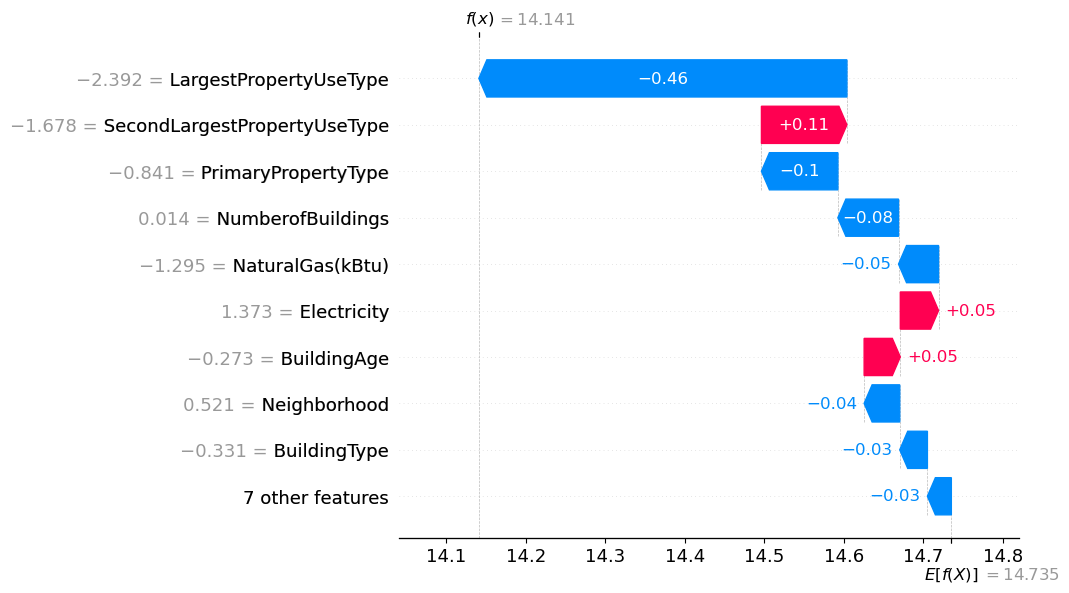


=== Traitement de la variante : brut_avec_ES ===


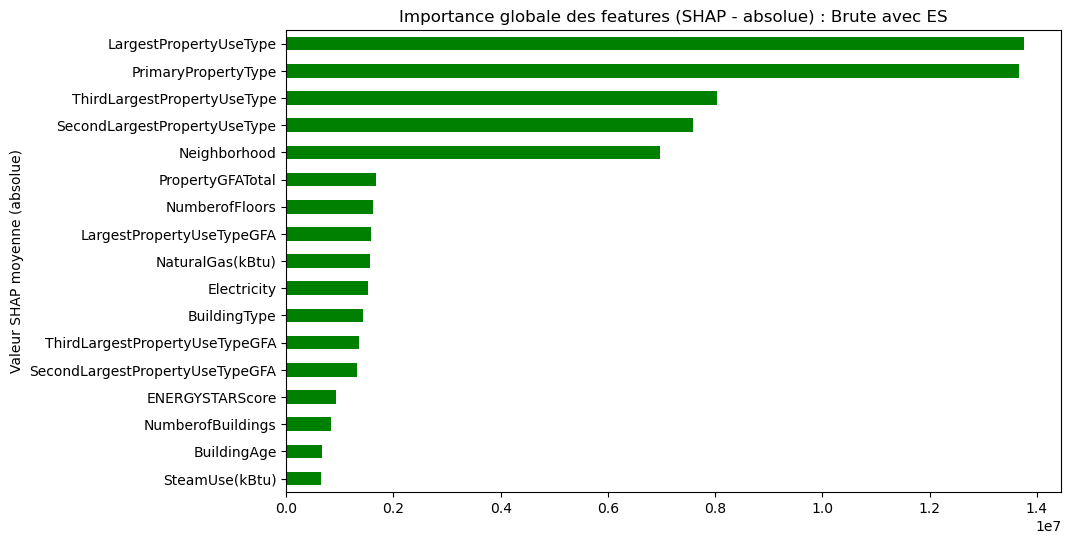

shap_aggregated_matrix.shape: (213, 17)
X_aggregated.shape: (213, 17)
Exemple d'observation agrégée: BuildingAge                       -0.122250
BuildingType                       0.051148
ENERGYSTARScore                    0.286408
Electricity                       -0.409166
LargestPropertyUseType             1.336800
LargestPropertyUseTypeGFA          0.612259
NaturalGas(kBtu)                   0.431911
Neighborhood                      -0.316763
NumberofBuildings                 -0.137717
NumberofFloors                     1.497733
PrimaryPropertyType                0.318721
PropertyGFATotal                   0.735439
SecondLargestPropertyUseType       1.591426
SecondLargestPropertyUseTypeGFA    0.602197
SteamUse(kBtu)                     0.631238
ThirdLargestPropertyUseType        2.154198
ThirdLargestPropertyUseTypeGFA     0.965874
Name: 0, dtype: float64


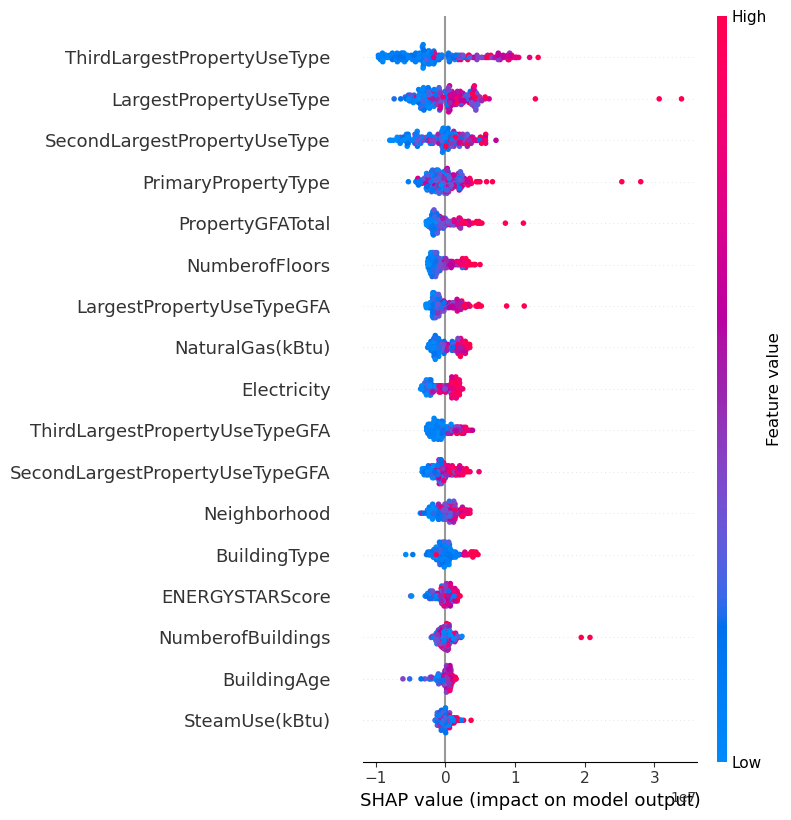

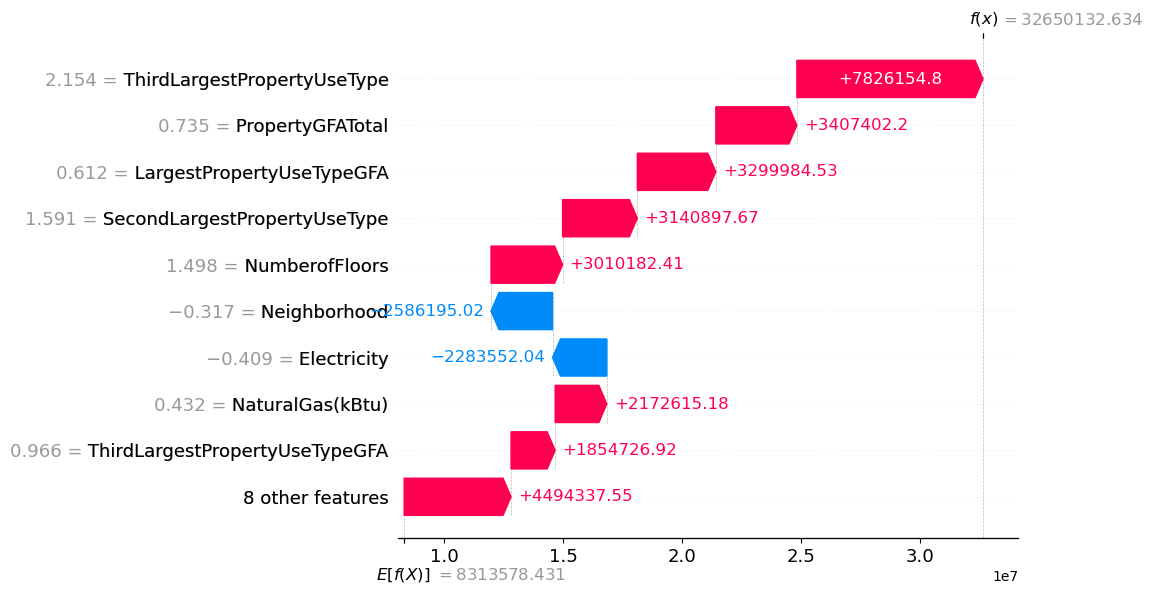

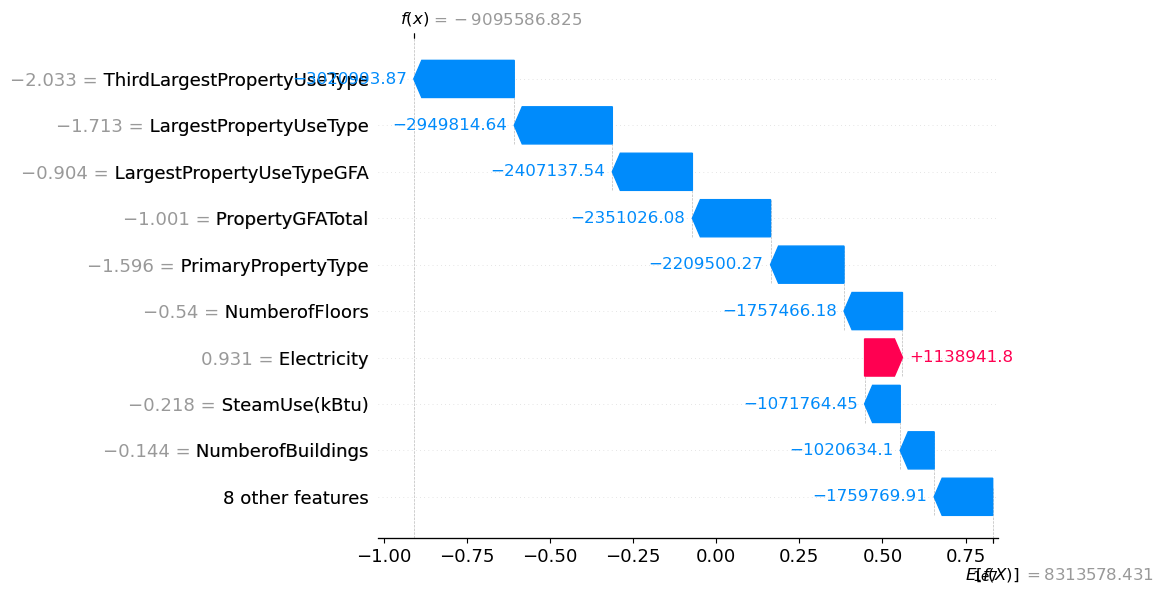


=== Traitement de la variante : log_avec_ES ===


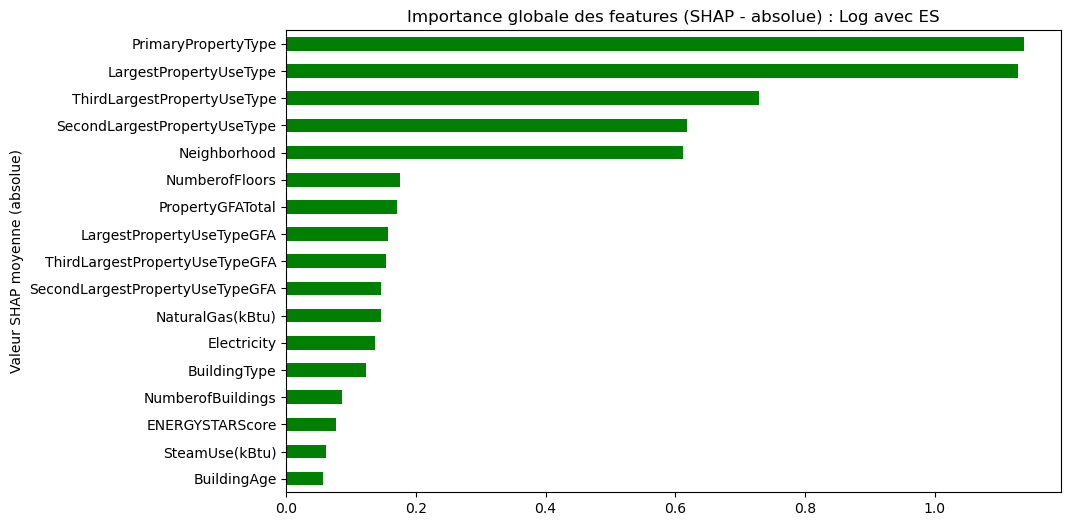

shap_aggregated_matrix.shape: (213, 17)
X_aggregated.shape: (213, 17)
Exemple d'observation agrégée: BuildingAge                       -0.122250
BuildingType                       0.051148
ENERGYSTARScore                    0.286408
Electricity                       -0.409166
LargestPropertyUseType             1.336800
LargestPropertyUseTypeGFA          0.612259
NaturalGas(kBtu)                   0.431911
Neighborhood                      -0.316763
NumberofBuildings                 -0.137717
NumberofFloors                     1.497733
PrimaryPropertyType                0.318721
PropertyGFATotal                   0.735439
SecondLargestPropertyUseType       1.591426
SecondLargestPropertyUseTypeGFA    0.602197
SteamUse(kBtu)                     0.631238
ThirdLargestPropertyUseType        2.154198
ThirdLargestPropertyUseTypeGFA     0.965874
Name: 0, dtype: float64


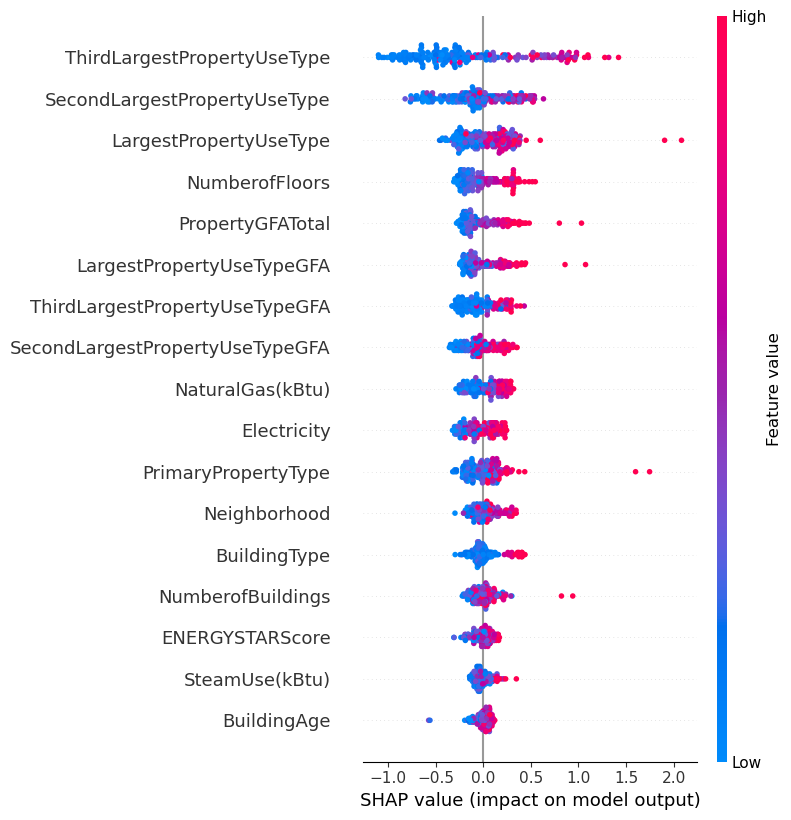

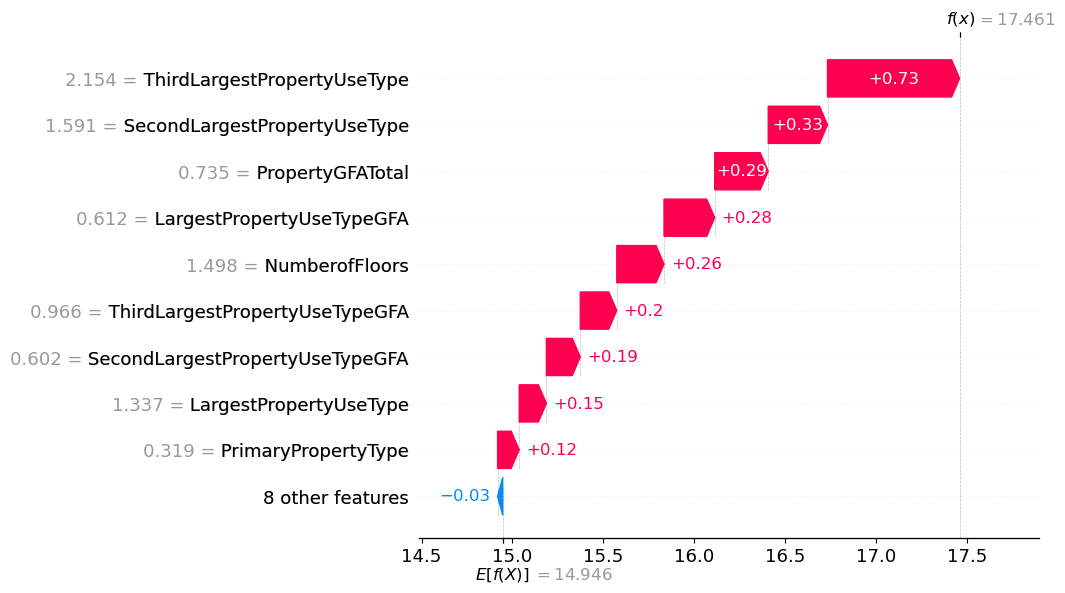

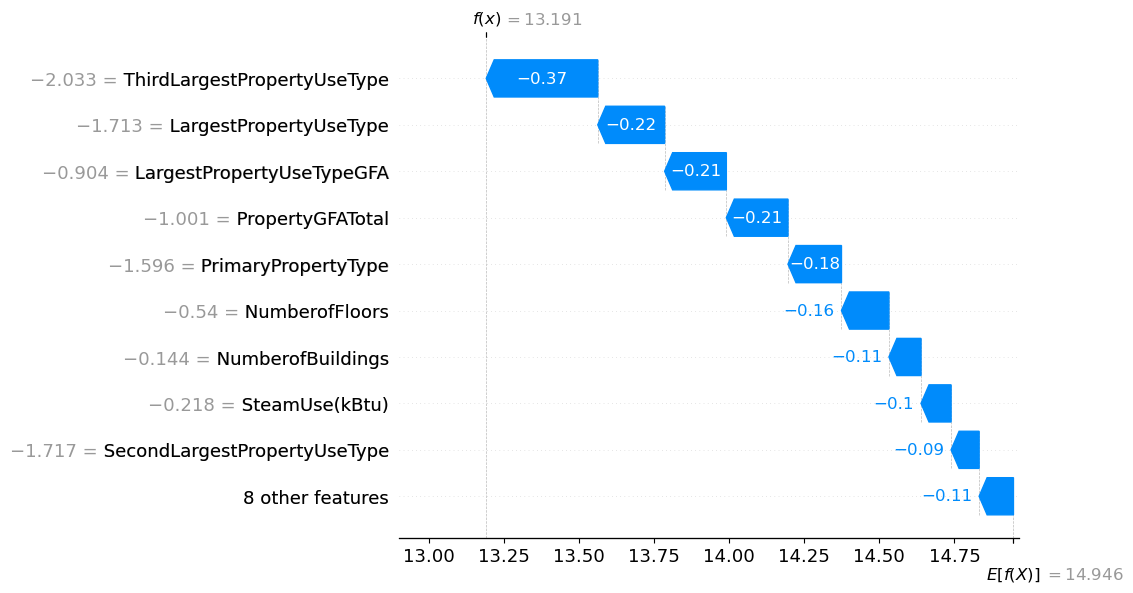

In [60]:

import shap

# Fonction pour extraire le nom de base d'une feature (ex. "Neighborhood_A" → "Neighborhood")
def nom_base_feature(name):
    return name.split('_')[0] if '_' in name else name
#Fonction pour calculer et créer les 3 graphiques de feature importance
def feature_importance(model, X_train_pca, X_test_pca, pca,
                       quanti, encoder, quali, X_train_final,
                       target_name="Target", obs_index=0):
    """
    Calcule les valeurs SHAP et génère 3 graphiques :
      - Barplot de l'importance globale (moyenne absolue)
      - Beeswarm plot basé sur l'agrégation locale des SHAP
      - Waterfall plot pour deux observations
     
    Parameters:
      model             : Modèle entraîné
      X_train_pca       : Données d'entraînement transformées par PCA
      X_test_pca        : Données de test transformées par PCA
      pca               : Objet PCA (pour inverse_transform)
      quanti            : Liste des features numériques
      encoder           : Objet OneHotEncoder
      quali             : Liste des noms des variables catégorielles
      target_name       : Nom descriptif de la variante
      obs_index         : Indice de l'observation pour le waterfall plot (par défaut 0)
    """
    # 1. Calcul des valeurs SHAP dans l'espace PCA
    explainer = shap.Explainer(model, X_train_pca)
    shap_values = explainer(X_test_pca)
    
    # 2. Rétro-projection : reconstruit les données d'origine et projette les SHAP
    X_test_original = pca.inverse_transform(X_test_pca)
    shap_values_original = shap_values.values @ pca.components_
    
    # 3. Récupération des noms de features (numériques + one-hot)
    feature_names = X_train_final.columns.tolist()
    
    # 4. Création d'un DataFrame des valeurs SHAP et application du mapping sur les colonnes
    shap_df = pd.DataFrame(shap_values_original, columns=feature_names)
    base_features = [nom_base_feature(col) for col in shap_df.columns]
    shap_df.columns = base_features
    
    # 5. Calcul global pour le barplot (moyenne absolue sur toutes les observations)
    # Ici, calcule de la moyenne sur l'axe 0, puis regroupe par le nom de feature.
    shap_aggregated_abs = shap_df.abs().mean(axis=0).groupby(lambda x: x).sum().sort_values(ascending=True)
    
    plt.figure(figsize=(10, 6))
    shap_aggregated_abs.plot(kind='barh', color='green')
    plt.title(f"Importance globale des features (SHAP - absolue) : {target_name}")
    plt.ylabel("Valeur SHAP moyenne (absolue)")
    plt.show()
    
    # 6. Agrégation locale des valeurs SHAP par observation :
    # Pour chaque observation, regroupe les colonnes identiques en sommant.
    # Utilisation de la transposition pour éviter le warning de groupby(axis=1).
    shap_aggregated_matrix = shap_df.T.groupby(lambda x: x).sum().T
    print("shap_aggregated_matrix.shape:", shap_aggregated_matrix.shape)
    
    # 7. Agrégation des données d'entrée de la même manière
    X_df = pd.DataFrame(X_test_original, columns=feature_names)
    X_df.columns = [nom_base_feature(col) for col in X_df.columns]
    X_aggregated = X_df.T.groupby(lambda x: x).sum().T
    print("X_aggregated.shape:", X_aggregated.shape)
    print("Exemple d'observation agrégée:", X_aggregated.iloc[0])
    
    # 8. Beeswarm plot : affiche la dispersion locale des valeurs SHAP agrégées
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_aggregated_matrix.values,  # (n_obs, n_features_origin)
        features=X_aggregated,            # (n_obs, n_features_origin)
        feature_names=X_aggregated.columns,
        plot_type="dot",
        show=True
    )
    
    # 9. Waterfall plot pour l'observation choisie (obs_index et, si disponible, obs 42)
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_aggregated_matrix.iloc[obs_index].values,
            base_values=shap_values.base_values[obs_index],
            data=X_aggregated.iloc[obs_index].values,
            feature_names=X_aggregated.columns
        )
    )
    if X_aggregated.shape[0] > 78:
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_aggregated_matrix.iloc[78].values,
                base_values=shap_values.base_values[78],
                data=X_aggregated.iloc[78].values,
                feature_names=X_aggregated.columns
            )
        )

# 2  variantes :
variantes = {
    "brute": {
        "model": best_model,
        "X_train_pca": X_train_pca_brut,
        "X_test_pca": X_test_pca_brut,
        "pca": pca_brut,
        "quanti": colonnes_quanti,
        "encoder": encoder,
        "quali": colonnes_quali,
        "X_train_final": X_train_final_brut,
        "target_name": "Brute sans ES"
    },
    "Transformé": {
        "model": best_model_transformed,
        "X_train_pca": X_train_pca_transformed,
        "X_test_pca": X_test_pca_transformed,
        "pca": pca_transformed,
        "quanti": colonnes_quanti_transformed,
        "encoder": encoder,
        "quali": colonnes_quali,
        "X_train_final": X_train_final_transformed,
        "target_name": "Log"
    },
    "brut_avec_ES": {
        "model": best_model_es,
        "X_train_pca": X_train_pca_brut_es,
        "X_test_pca": X_test_pca_brut_es,
        "pca": pca_brut_es,
        "quanti": features_quanti_ES, 
        "encoder": encoder,
        "quali": features_quali,
        "X_train_final": X_train_final_brut_es,
        "target_name": "Brute avec ES"
    },
    "log_avec_ES": {
        "model": best_model_log_es,
        "X_train_pca": X_train_pca_transformed_es,
        "X_test_pca": X_test_pca_transformed_es,
        "pca": pca_transformed_es,
        "quanti": features_quanti_transformed_ES,
        "encoder": encoder,
        "quali": features_quali,
        "X_train_final": X_train_final_transformed_es,
        "target_name": "Log avec ES"
    }
}

# Boucle sur les variantes 
for variant_name, params in variantes.items():
    print(f"\n=== Traitement de la variante : {variant_name} ===")
    feature_importance(
        model=params["model"],
        X_train_pca=params["X_train_pca"],
        X_test_pca=params["X_test_pca"],
        pca=params["pca"],
        quanti=params["quanti"],
        encoder=params["encoder"],
        quali=params["quali"],
        X_train_final = params["X_train_final"],
        target_name=params["target_name"],
        obs_index=0 
    )


In [61]:
i=78
print(f"Observation {i} dans df_final :")
print(df_final.iloc[i])

Observation 78 dans df_final :
OSEBuildingID                                            117
DataYear                                                2016
BuildingType                                  NonResidential
PrimaryPropertyType                                    Hotel
PropertyName                                  UNIVERSITY INN
Address                                4140 ROOSEVELT WAY NE
City                                                 Seattle
State                                                     WA
ZipCode                                              98105.0
TaxParcelIdentificationNumber                     1142001871
CouncilDistrictCode                                        4
Neighborhood                                       NORTHEAST
Latitude                                            47.65772
Longitude                                         -122.31756
YearBuilt                                               1962
NumberofBuildings                                     